<a href="https://colab.research.google.com/github/prasanna-gaddad/Flight-Fare-Prediction/blob/main/Fake_or_Real_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load dataset From Kaggle to Google Colab page

#!kaggle datasets download -d icw123/glove-twitter
#!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

#!cp /content/drive/MyDrive/kagelle/kaggle.json ~/.kaggle/kaggle.json

#%cd /content/data

#!kaggle datasets download -d icw123/glove-twitter
#!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

#!unzip fake-and-real-news-dataset.zip
#!unzip glove-twitter.zip

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
true = pd.read_csv('/content/data/True.csv')
false = pd.read_csv('/content/data/Fake.csv')

DATA VISUALIZATION AND PREPROCESSING

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true['category'] = 1
false['category'] = 0

In [7]:
df = pd.concat([true,false]) #Merging the 2 datasets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


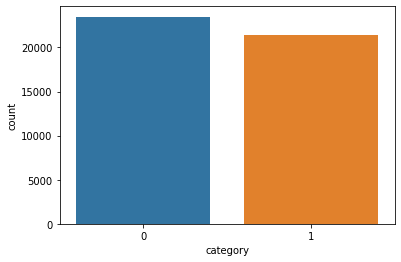

In [8]:
sns.countplot(df.category)

SO, WE CAN SEE THAT THE DATASET IS BALANCED

In [9]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [10]:
df.shape

(44898, 5)

In [11]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

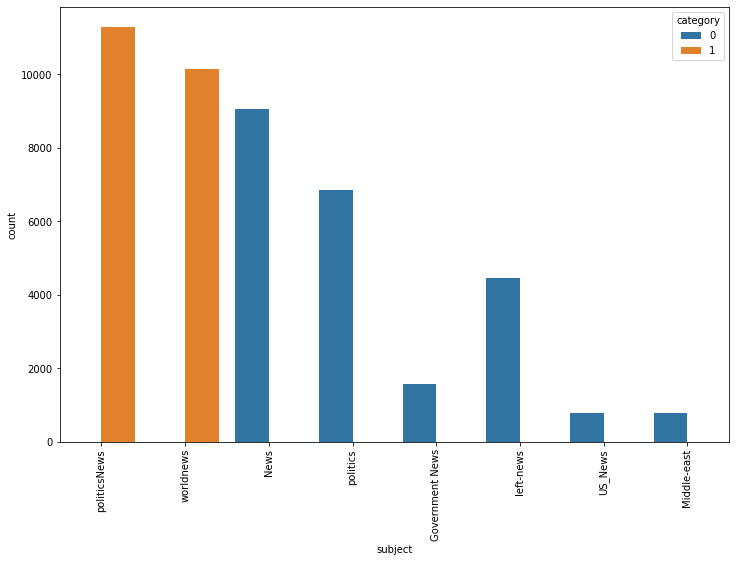

In [12]:
plt.figure(figsize = (12,8))

chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

SINCE THE TOPICS IN SUBJECT COLUMN ARE DIFFERENT FOR BOTH CATEGORIES, HENCE WE HAVE TO EXCLUDE IT FROM FINAL TEXT COLUMN

In [13]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [14]:
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


WHAT ARE STOPWORDS?

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.

In [15]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

DATA CLEANING

In [16]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets1(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets2(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    #text = strip_html(text)
    text = remove_between_square_brackets1(text)
    text = remove_between_square_brackets2(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['text']=df['text'].apply(denoise_text)

WORDCLOUD FOR REAL TEXT (LABEL - 1)

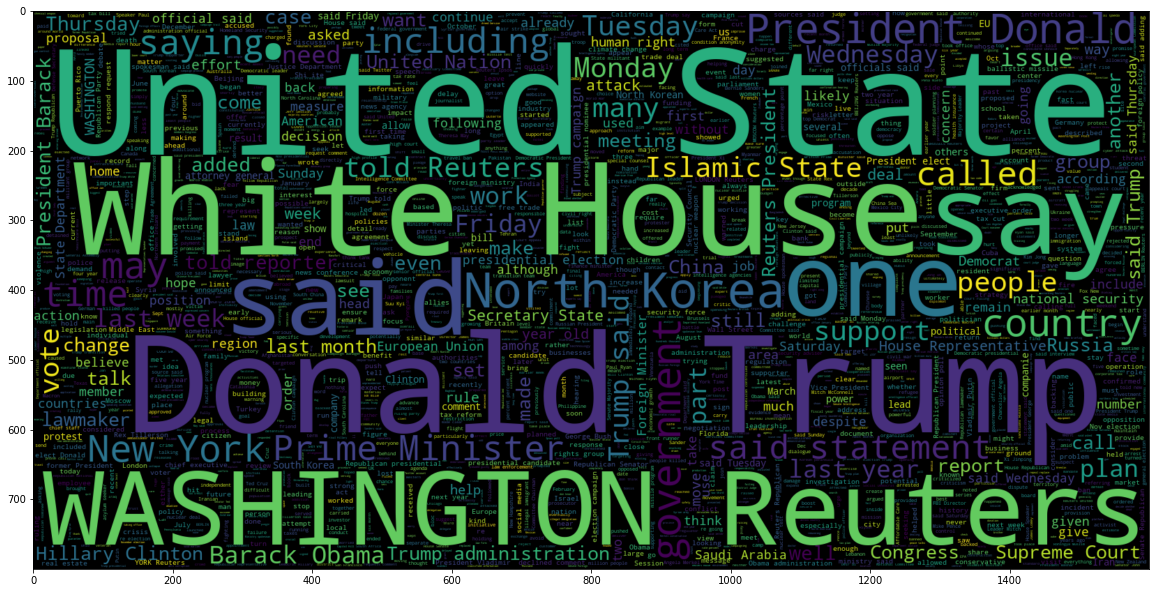

In [17]:
plt.figure(figsize = (20,20)) # Text that is not Fake

wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))

plt.imshow(wc , interpolation='bilinear')

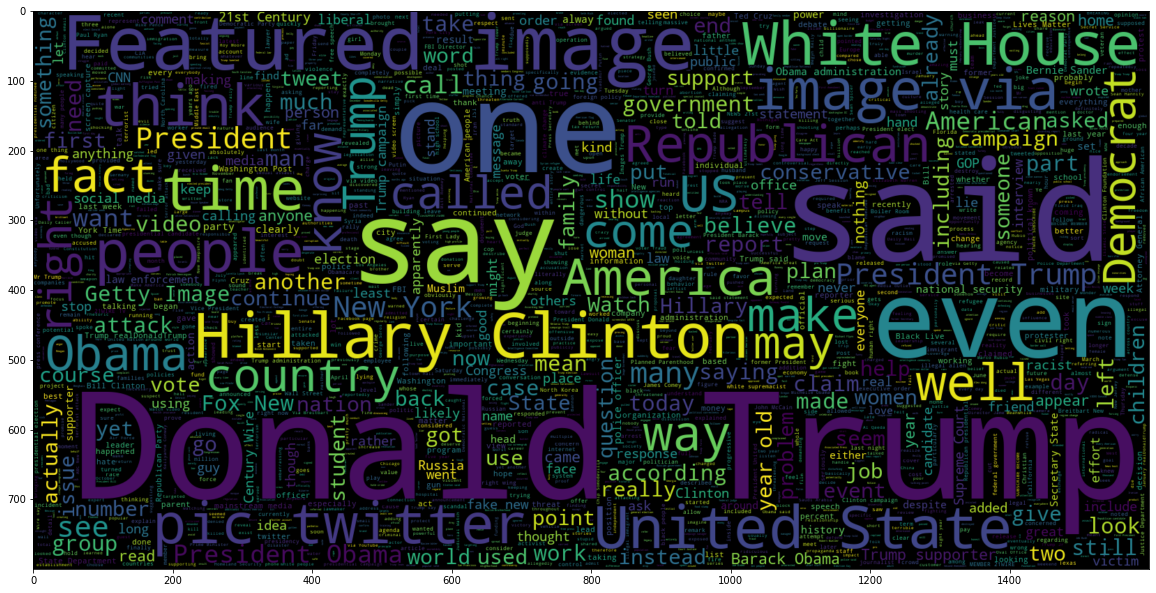

In [18]:
plt.figure(figsize = (20,20)) # Text that is Fake

wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))

plt.imshow(wc , interpolation='bilinear')

Number of characters in texts

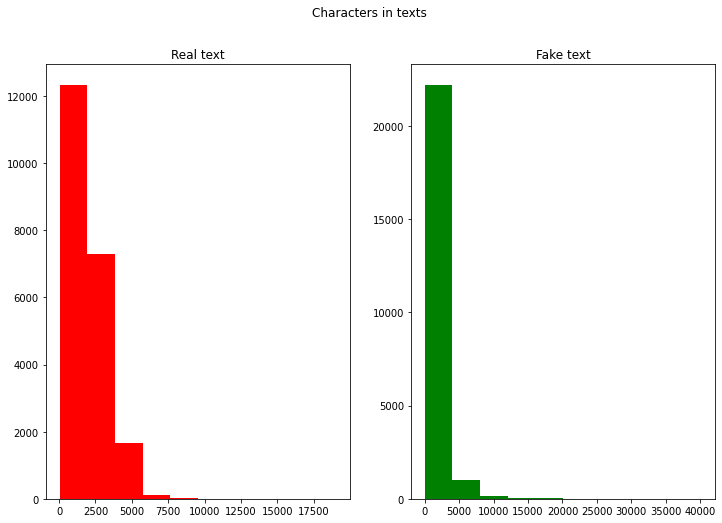

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Real text')

text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')

fig.suptitle('Characters in texts')
plt.show()

The distribution of both seems to be a bit different. 2500 characters in text is the most common in Real text category while around 5000 characters in text are most common in fake text category

Number of words in each text

Text(0.5, 0.98, 'Words in texts')

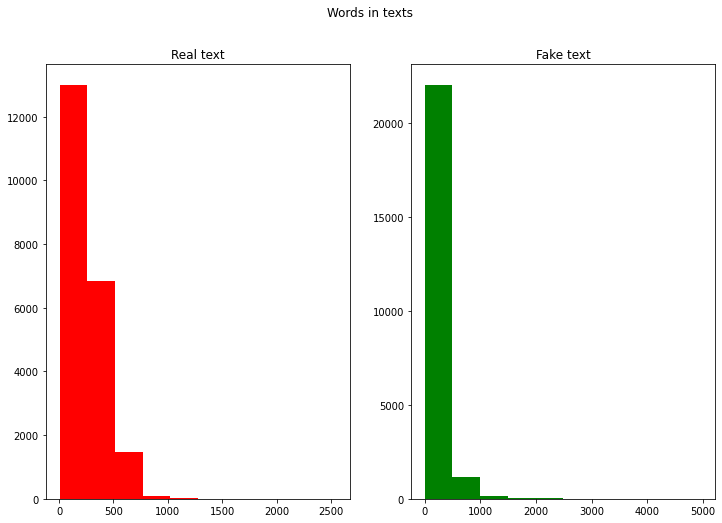

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len = df[df['category'] == 1]['text'].str.split().apply(lambda x :len(x))
ax1.hist(text_len , color='red')
ax1.set_title('Real text')

text_len = df[df['category'] == 0]['text'].str.split().apply(lambda x :len(x))
ax2.hist(text_len , color='green')
ax2.set_title('Fake text')

fig.suptitle('Words in texts')

Average word length in a text

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

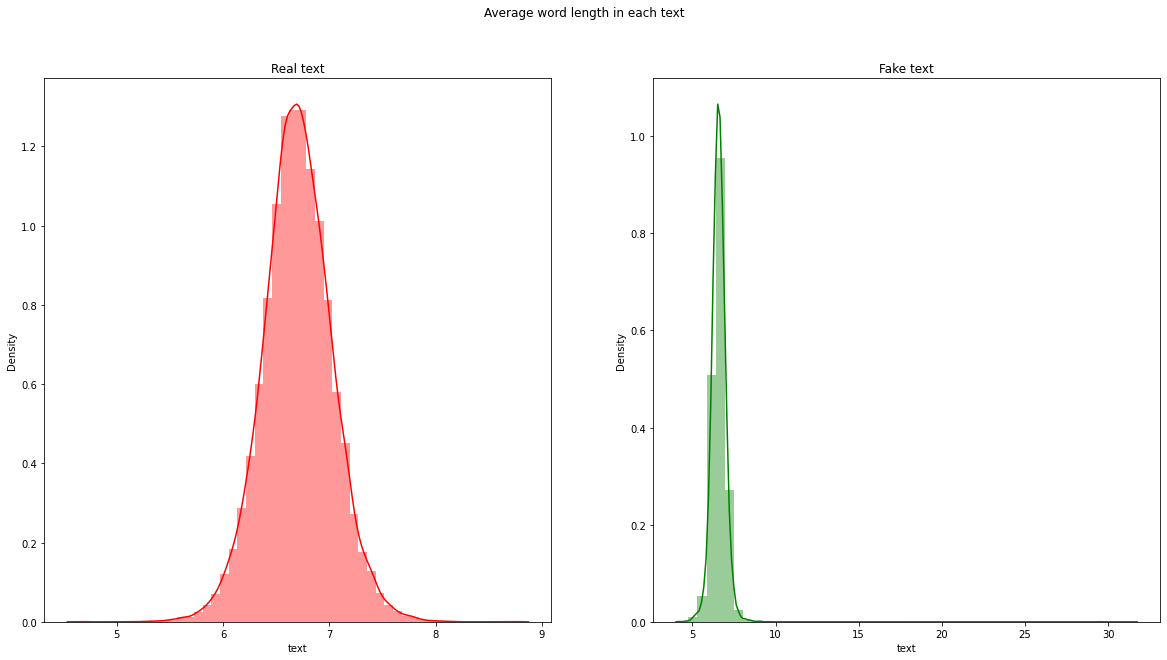

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

word = df[df['category'] == 1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.apply(lambda x : np.mean(x)) ,ax = ax1 , color='red')
ax1.set_title('Real text')

word = df[df['category'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.apply(lambda x : np.mean(x)) ,ax = ax2 , color='green')
ax2.set_title('Fake text')

fig.suptitle('Average word length in each text')

In [22]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
    
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [23]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Donald': 27796,
 'President': 33171,
 'Trump': 111486,
 'U.S.': 50430,
 'also': 30316,
 'one': 29363,
 'people': 33107,
 'said': 93144,
 'said.': 26193,
 'would': 54601}

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Unigram Analysis

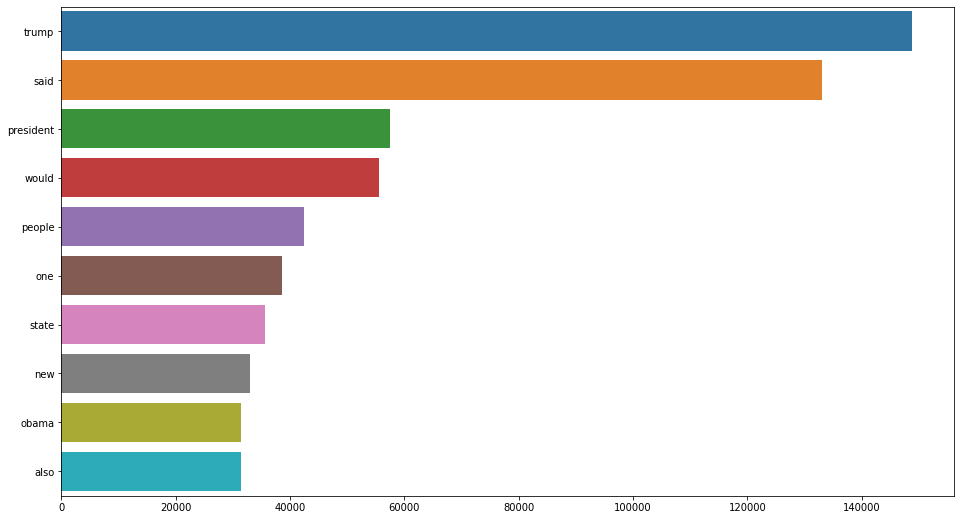

In [25]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

Bigram Analysis

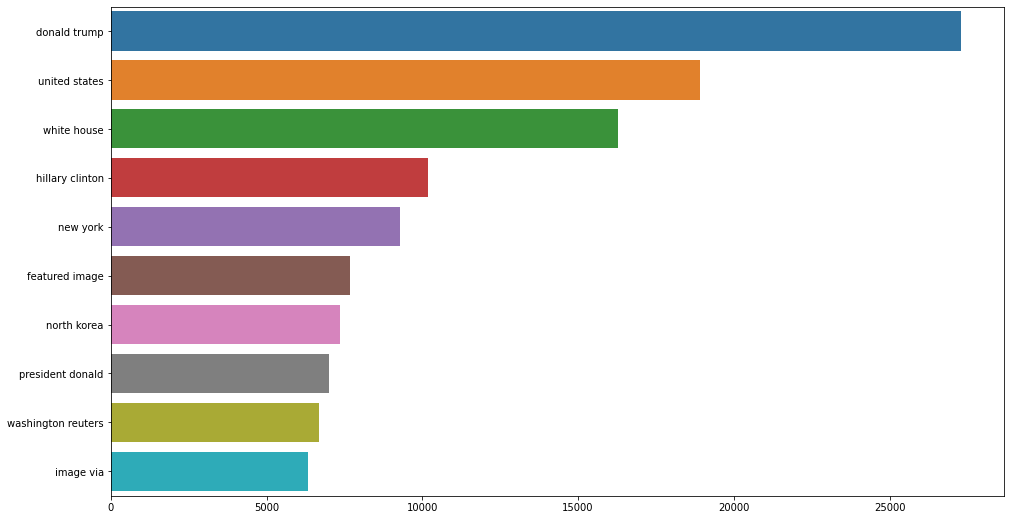

In [26]:
plt.figure(figsize=(16,9))

most_common_bi = get_top_text_ngrams(df.text , 10 , 2)

most_common_bi = dict(most_common_bi)

sns.barplot(x = list(most_common_bi.values()) , y = list(most_common_bi.keys()) )

Trigram Analysis

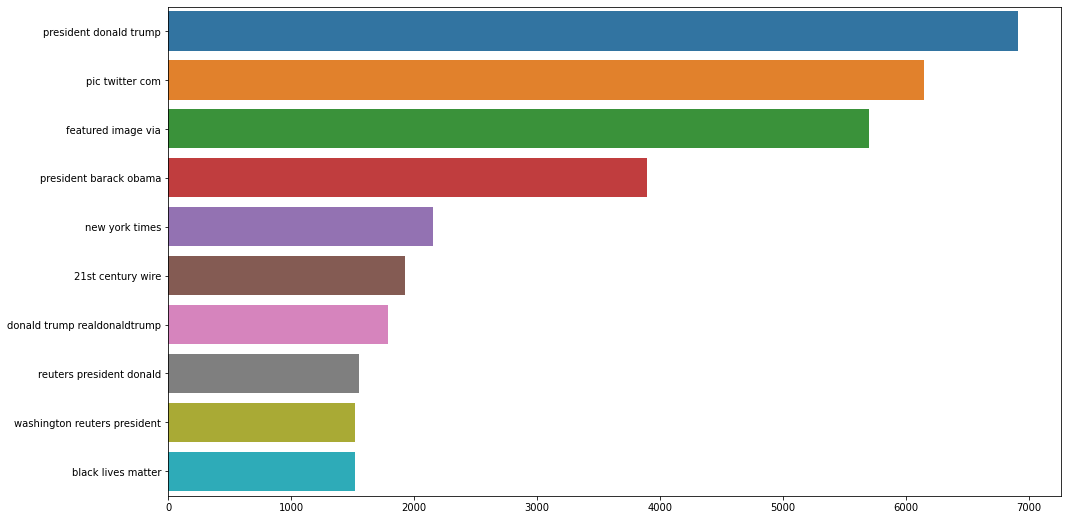

In [27]:
plt.figure(figsize=(16,9))

most_common_tri = get_top_text_ngrams(df.text , 10 , 3)

most_common_tri = dict(most_common_tri)

sns.barplot(x = list(most_common_tri.values()) , y = list(most_common_tri.keys()) )

Splitting the data into 2 parts - training and testing data

In [28]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [30]:
max_features = 10000
maxlen = 300

Tokenizing Text -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [31]:
tokenizer = text.Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)

x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [32]:
tokenized_test = tokenizer.texts_to_sequences(x_test)

X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

GloVe method is built on an important idea, You can derive semantic relationships between words from the co-occurrence matrix. Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.

The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix. How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.

In [33]:
EMBEDDING_FILE = '/content/data/glove.twitter.27B.100d.txt'

In [34]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
    
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [35]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


Some Model Parameters

In [36]:
batch_size = 256
epochs = 10
embed_size = 100

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

TRAINING THE MODEL

In [40]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [43]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 276s 2s/step - loss: 0.3576 - accuracy: 0.8350 - val_loss: 0.0312 - val_accuracy: 0.9900
Epoch 2/10
132/132 [==============================] - 264s 2s/step - loss: 0.0241 - accuracy: 0.9925 - val_loss: 0.0143 - val_accuracy: 0.9953
Epoch 3/10
132/132 [==============================] - 263s 2s/step - loss: 0.0131 - accuracy: 0.9958 - val_loss: 0.0123 - val_accuracy: 0.9964
Epoch 4/10
132/132 [==============================] - 268s 2s/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.0116 - val_accuracy: 0.9962
Epoch 5/10
132/132 [==============================] - 267s 2s/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0092 - val_accuracy: 0.9966
Epoch 6/10
132/132 [==============================] - 267s 2s/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.0090 - val_accuracy: 0.9974
Epoch 7/10
132/132 [==============================] - 260s 2s/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.0088 - val_accuracy: 0.9983

ANALYSIS AFTER TRAINING OF MODEL

In [44]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 124s 118ms/step - loss: 0.0012 - accuracy: 0.9997
Accuracy of the model on Training Data is -  99.97327327728271 %
351/351 [==============================] - 41s 117ms/step - loss: 0.0062 - accuracy: 0.9982
Accuracy of the model on Testing Data is -  99.82182383537292 %


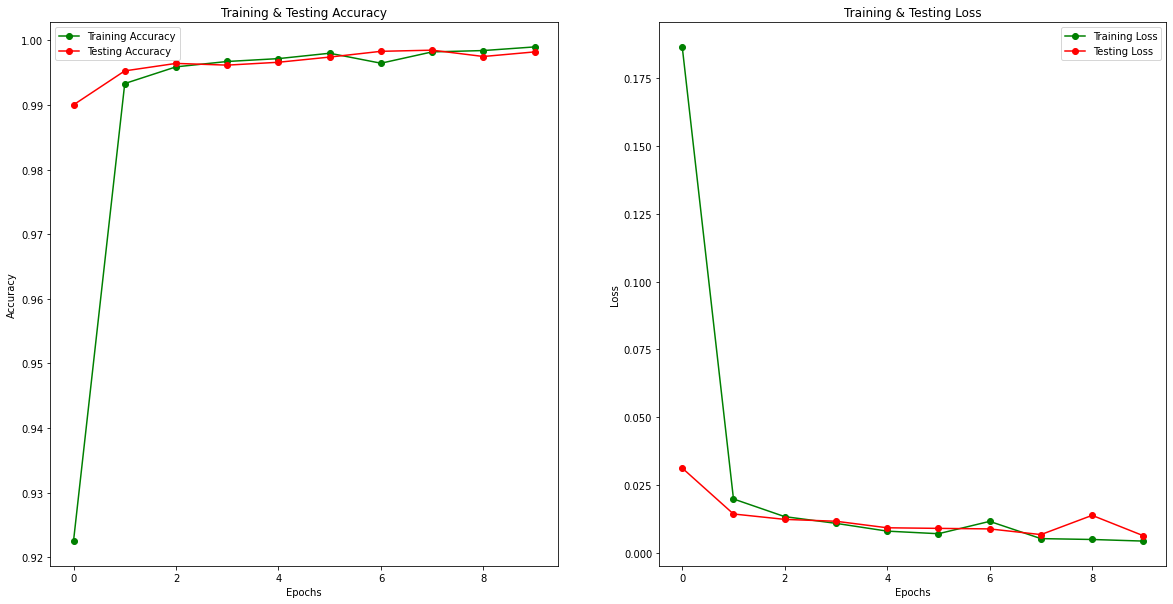

In [45]:
epochs = [i for i in range(10)]

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [46]:
pred = model.predict_classes(X_test)
pred[:10]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

In [47]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [48]:
cm = confusion_matrix(y_test,pred)
cm

array([[5845,   13],
       [   7, 5360]])

In [49]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

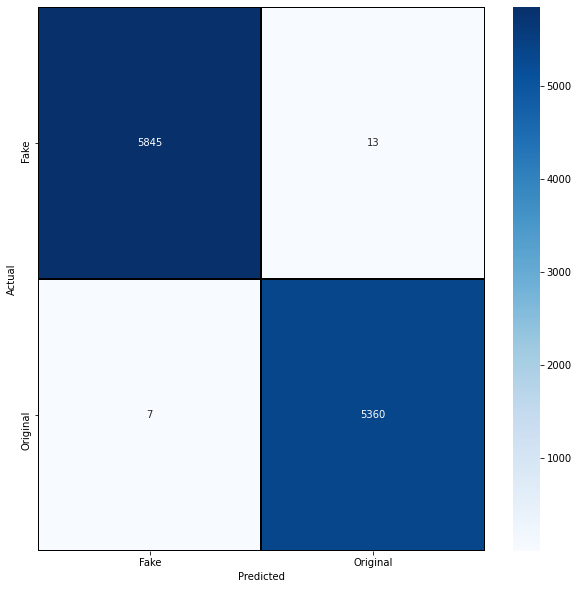

In [50]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
# Save Model

#model.save('/content/model.h5')

In [51]:
# Save requirements.txt file

!pip freeze > requirements.txt